# Simple Linear Regression
Predict sales using an appropriate predictor variable

## Import necessary libraries

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

## Load dataset and have initial look and feel

In [56]:
df = pd.read_csv('advertising.csv')
df.head(5)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.4 KB


## Visualise data

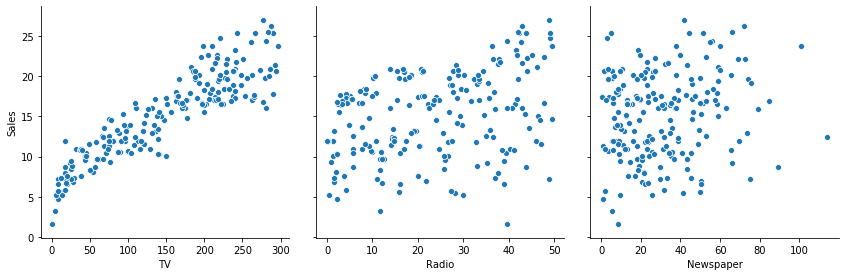

In [58]:
sns.pairplot(df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', height=4, aspect=1)
plt.show()

The scatter plot suggests linear relationship between TV and Sales

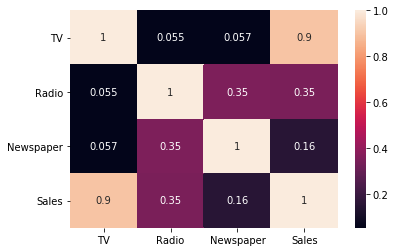

In [59]:
sns.heatmap(df.corr(), annot=True)
plt.show()

The heatmap confirms that we have strong positive correlation between TV and sales

## Model building using statsmodels

### Prepare X and y

In [60]:
X = df['TV']
y = df['Sales']

### Train test split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

In [62]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((140,), (140,), (60,), (60,))

As we are dealing with only one independent variable we dont need normalisation of the data

## Build model using statsmodels

### Adding a constant to get intercept
The statsmodels always fits a line that goes through origin i.e whose intercept is 0. To get a line with an intercept we do a nice hack. We introduce another variable in X which has all elements set to 1. So that any intercept 'c' that we get will multiply with this value 1 and remain as c.

In [63]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [64]:
X_train_sm.head()

,const,TV
74,1.0,213.4
3,1.0,151.5
185,1.0,205.0
26,1.0,142.9
90,1.0,134.3


### Building the mode using  OLS

In [67]:
ols = sm.OLS(y_train, X_train_sm)
reg_results_wrapper = ols.fit()

### Look at the params

In [68]:
reg_results_wrapper.params

const    6.948683
TV       0.054546
dtype: float64

### Lets look at the summary of the regression results wrapper

In [72]:
print(reg_results_wrapper.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     611.2
Date:                Thu, 13 May 2021   Prob (F-statistic):           1.52e-52
Time:                        19:49:58   Log-Likelihood:                -321.12
No. Observations:                 140   AIC:                             646.2
Df Residuals:                     138   BIC:                             652.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9487      0.385     18.068      0.0

####  Looking at some key statistics from the summary

The values we are concerned with are - 
1. The coefficients and significance (p-values)
2. R-squared
3. F statistic and its significance

##### 1. The coefficient for TV is 0.054, with a very low p value
The coefficient is statistically significant. So the association is not purely by chance. 

##### 2. R - squared is 0.816
Meaning that 81.6% of the variance in `Sales` is explained by `TV`

This is a decent R-squared value.

###### 3. F statistic has a very low p value (practically low)
Meaning that the model fit is statistically significant, and the explained variance isn't purely by chance.

### Lets visualise the model

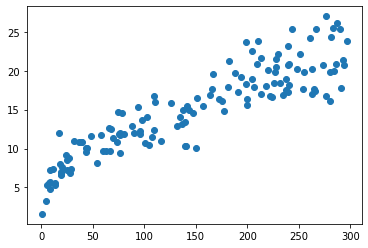

In [76]:
plt.scatter(X_train, y_train)
plt.plot(X_train, reg_results_wrapper.params)
plt.show()